**Import Libraries**

In [0]:
!pip install xgboost
!pip install librosa

In [0]:
import os
import glob
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import fftpack
from scipy.stats import kurtosis,skew,mode
import sklearn.preprocessing,sklearn.decomposition
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold,train_test_split
from keras import utils
import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv1D, Conv2D, Flatten,Reshape, BatchNormalization, ZeroPadding2D,MaxPooling1D,AveragePooling1D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras import regularizers,optimizers
from keras.optimizers import SGD,adam
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping


**Extract Training Dataset**

In [0]:
def get_training_data(path_to_dataset):
  """
  Loads the training dataset audio files using Librosa and saves them as numpy arrays and Spectrogram Images.
   1.path_to_dataset = Path to the Dataset
  """
  # Load the training data csv file into a dataframe.
  df = pd.read_csv(os.path.join(path_to_dataset,'train.csv'))

  # Create directories to store the Numpy arrays if they don't exist.
  if not os.path.exists(os.path.join(path_to_dataset,'train_extracted')):
    os.makedirs(os.path.join(path_to_dataset,'train_extracted'))
  
  # Getting the file names of audios from the dataframe.
  audio_files = np.array(df['new_id'])

  # Load each audio file, Save it as a numpy and Spectrogram Image.
  for i in range(len(audio_files)):    
    d,r = librosa.load(os.path.join(path_to_dataset,'train',str(audio_files[i]).zfill(8)+".mp3"),mono=True)
    np.save(os.path.join(path_to_dataset, 'train_extracted',str(audio_files[i])+'.npy'),d)
    #save_spectograms(d,r,audio_files[i],os.path.join(path_to_dataset,'train_spectograms'))

**Extract Testing Dataset**

In [0]:
def get_testing_data(path_to_dataset):
  """
  Loads the test dataset audio files using Librosa and saves them as numpy arrays and Spectrogram Images.
   1.path_to_dataset = Path to the Dataset
  """
  # Load the test data csv file into a dataframe.
  df = pd.read_csv(os.path.join(path_to_dataset,'test_idx.csv'))

  # Create directories to store the Numpy arrays and Images if they don't exist.
  if not os.path.exists(os.path.join(path_to_dataset,'test_extracted')):
    os.makedirs(os.path.join(path_to_dataset,'test_extracted'))
  
  # Getting the file names of audios from the dataframe.
  audio_files = np.array(df['new_id'])

  # Load each audio file, Save it as a numpy and Spectrogram Image.
  for i in range(len(audio_files)):   
    d,r = librosa.load(os.path.join(path_to_dataset,'test',str(audio_files[i]).zfill(8)+".mp3"),mono=True)
    np.save(os.path.join(path_to_dataset, 'test_extracted',str(audio_files[i])+'.npy'),d)
    #save_spectograms(d,r,audio_files[i],os.path.join(path_to_dataset,'test_spectrograms'))


In [0]:
def save_spectograms(data,sampling_rate,filename,path_to_dir):
  """
  Plot and save spectrograms for the given audio sequence in the specified folder.
   1. data = Audio file sequence loaded using Librosa.
   2. sampling_rate = Sampling rate with which the audio sequence loaded using librosa.
   3. filename = Audio File name to save the spectrogram with same name.
   4. path_to_dir = Path to the folder to save the spectrogram.
  """
  # Calculate the spectrogram for the audio sequence.
  mel_spect = librosa.feature.melspectrogram(data, sr=sampling_rate, n_mels=128)

  # Applying logarthim on top.
  log_mel_spect = librosa.amplitude_to_db(mel_spect, ref=np.max)

  # Displaying the spectrogram and plotting it using matplotlib.
  librosa.display.specshow(log_mel_spect, sr=sampling_rate)
  fig_axes = plt.gca()
  current_figure = plt.gcf()
  fig_axes.axes.get_xaxis().set_visible(False)
  fig_axes.axes.get_yaxis().set_visible(False)
  current_figure.set_size_inches(5, 5)

  # Saving the plotted figure.
  plt.savefig(os.path.join(path_to_dir,str(filename)+'.png'), bbox_inches='tight',pad_inches=-0.1)
  plt.close()

**Extract MFCC Features**

In [0]:
def get_mfcc_features(path_to_dataset, csvfile, extracted_folder):
  """
  Calculate and return MFCCs for the audio sequence arrays in the specified folder.
   1.path_to_dataset = Path to the Dataset.
   2.csvfile = csv file with audio file names. 
   3.extracted_folder = Folder containing the audio sequence arrays.
  """
  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(path_to_dataset, csvfile ))

  # Get the audio file names.
  audio_extracted = np.array(df['new_id'])

  # Create an empty list.
  mfcc_features=list()

  # Looping on each Audio sequence array.
  for i in range(len(audio_extracted)):
    # Load the Audio sequence.
    audio_file_data= np.load(os.path.join(path_to_dataset, extracted_folder, str(audio_extracted[i])+'.npy'))

    # Calculate MFCC coefficients for the audio sequence.
    mfcc_data = librosa.feature.mfcc(y=audio_file_data,sr=22050)

    # Calculating various statistic measures on the coefficients.
    mean_mfcc = np.mean(mfcc_data, axis=1)
    median_mfcc= np.median(mfcc_data,axis=1)
    std_mfcc = np.std(mfcc_data, axis=1)
    skew_mfcc = skew(mfcc_data, axis=1)
    kurt_mfcc = kurtosis(mfcc_data, axis=1)
    maximum_mfcc = np.amax(mfcc_data, axis=1)
    minimum_mfcc = np.amin(mfcc_data, axis=1)

    # Concatinating all the statistic measures and adding to the feature list.
    addList = np.concatenate((mean_mfcc,median_mfcc,std_mfcc,skew_mfcc,kurt_mfcc,maximum_mfcc,minimum_mfcc))
    mfcc_features.append(addList) 
  # Return feature list.
  return mfcc_features

**Extract STFT Features**

In [0]:
def get_stft_features(path_to_dataset, csvfile, extracted_folder):
  """
  Calculate and return Short Term Fourier Transform for the audio sequence arrays in the specified folder.
   1.path_to_dataset = Path to the Dataset.
   2.csvfile = csv file with audio file names. 
   3.extracted_folder = Folder containing the audio sequence arrays.
  """
  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(path_to_dataset, csvfile ))

  # Get the audio file names.
  audio_extracted = np.array(df['new_id'])

  # Create an empty list.
  time_series_features=list()

  # Looping on each Audio sequence array.
  for i in range(len(audio_extracted)):

    # Load the Audio sequence.
    time_series= np.load(os.path.join(path_to_dataset, extracted_folder, str(audio_extracted[i])+'.npy'))

    # Calculate STFTs for the audio sequence and trucating every row to 1000 values for consistency.
    stft = np.abs(librosa.core.stft(time_series)[:,:1000])

    # Calculating various statistic measures on the STFTs.
    mean_stft = np.mean(stft, axis=1)
    median_stft= np.median(stft,axis=1)
    std_stft = np.std(stft, axis=1)
    skew_stft = skew(stft, axis=1)
    kurt_stft = kurtosis(stft, axis=1)
    maximum_stft = np.amax(stft, axis=1)
    minimum_stft = np.amin(stft, axis=1)
  
    # Concatinating all the statistic measures and adding to the feature list.
    addList = np.concatenate((mean_stft,median_stft,std_stft,skew_stft,kurt_stft,maximum_stft,minimum_stft)) 
    time_series_features.append(addList)  

  # Return feature list.
  return time_series_features

**Extract All Features For PCA**

In [0]:
def get_all_features(path_to_dataset, csvfile, extracted_folder):
  """
  Calculate and return features using all important methods for the audio sequence arrays in the specified folder.
   1.path_to_dataset = Path to the Dataset.
   2.csvfile = csv file with audio file names. 
   3.extracted_folder = Folder containing the audio sequence arrays.
  """
  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(path_to_dataset, csvfile ))

  # Get the audio file names.
  audio_extracted = np.array(df['new_id'])

  # Create an empty list.
  all_features=list()

  # Looping on each Audio sequence array.
  for i in range(len(audio_extracted)):

    # Load the Audio sequence.
    audio_file_data= np.load(os.path.join(path_to_dataset, extracted_folder, str(audio_extracted[i])+'.npy'))

    # Calculate MFCC on the audio sequence.
    mfcc_data = librosa.feature.mfcc(y=audio_file_data,sr=22050)

    # Calculate Root Mean Square Error.
    rmse= librosa.feature.rmse(y=audio_file_data)

    # Calculate Chroma STFTs.
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio_file_data, sr=22050))

    # Calculate Spectral Centroid.
    spec_cent = librosa.feature.spectral_centroid(y=audio_file_data, sr=22050)

    # Calculate Spectral Bandwidth.
    spec_bw = librosa.feature.spectral_bandwidth(y=audio_file_data, sr=22050)

    # Calculate Rolloff.
    rolloff = librosa.feature.spectral_rolloff(y=audio_file_data, sr=22050)

    # Calculate Zero Crossing Rate.
    zcr =librosa.feature.zero_crossing_rate(audio_file_data)

    # Calculate and append statistic features for all the above data features.
    addList = np.concatenate((np.mean(mfcc_data, axis=1),np.median(mfcc_data,axis=1),np.std(mfcc_data, axis=1),skew(mfcc_data, axis=1),kurtosis(mfcc_data, axis=1),np.atleast_1d(np.mean(rmse)),np.atleast_1d(np.median(rmse)),np.atleast_1d(np.std(rmse)),np.atleast_1d(skew(rmse,axis=1)),np.atleast_1d(kurtosis(rmse,axis=1)),np.atleast_1d(np.mean(chroma_stft)),np.atleast_1d(np.median(chroma_stft)),np.atleast_1d(np.std(chroma_stft)),np.atleast_1d(skew(chroma_stft)),np.atleast_1d(kurtosis(chroma_stft)),np.atleast_1d(np.mean(spec_cent)),np.atleast_1d(np.median(spec_cent)),np.atleast_1d(np.std(spec_cent)),np.atleast_1d(skew(spec_cent,axis=1)),np.atleast_1d(kurtosis(spec_cent,axis=1)),np.atleast_1d(np.mean(spec_bw)),np.atleast_1d(np.median(spec_bw)),np.atleast_1d(np.std(spec_bw)),np.atleast_1d(skew(spec_bw,axis=1)),np.atleast_1d(kurtosis(spec_bw,axis=1)),np.atleast_1d(np.mean(rolloff)),np.atleast_1d(np.median(rolloff)),np.atleast_1d(np.std(rolloff)),np.atleast_1d(skew(rolloff,axis=1)),np.atleast_1d(kurtosis(rolloff,axis=1)),np.atleast_1d(np.mean(zcr)),np.atleast_1d(np.median(zcr)),np.atleast_1d(np.std(zcr)),np.atleast_1d(skew(zcr,axis=1)),np.atleast_1d(kurtosis(zcr,axis=1)),np.amax(mfcc_data, axis=1),np.amin(mfcc_data, axis=1)))
    all_features.append(addList) 
  return all_features

**Apply PCA on All Features**

In [0]:
def get_pca_features(path_to_dataset, train_csvfile, train_extracted_folder,test_csvfile, test_extracted_folder,no_of_components):
  """
  Calculate and return features using all important methods for the audio sequence arrays in the specified folders.
   1.path_to_dataset = Path to the Dataset.
   2.csvfile = csv file with audio file names. 
   3.extracted_folder = Folder containing the audio sequence arrays.
  """

  # Extract all the best features for the train and test audio sequences.
  train_features=get_all_features(path_to_dataset, train_csvfile, train_extracted_folder)
  test_features =get_all_features(path_to_dataset, test_csvfile, test_extracted_folder)

  # Standardize the features.
  sc = StandardScaler(with_mean=False)
  train_features = sc.fit_transform(train_features)
  test_features = sc.transform(test_features)

  # Apply PCA with no of components satisfying the explained variance ratio.
  pca = sklearn.decomposition.PCA()
  pca.fit(train_features)
  cumsum = np.cumsum(pca.explained_variance_ratio_)
  no_of_components = np.argmax(cumsum >= 0.95) + 1
  pca = sklearn.decomposition.PCA(n_components=no_of_components)

  # Fit and Transform training and testing data.
  train_features = pca.fit_transform(train_features)
  test_features = pca.transform(test_features)
  return train_features,test_features

**Extract Spectrograms**

In [0]:
def get_spectrograms(path_to_dataset, csvfile1, extracted_folder1,csvfile2, extracted_folder2):
  """
  Returns the Mel-Spectrograms of the Training and Testing Datasets.
   1.path_to_dataset = Path to the Dataset.
   2.csvfile1 = csv file with Training Dataset audio file names. 
   3.extracted_folder1 = Folder containing Training Dataset audio sequence arrays.
   4.csvfile2 = csv file with Testing Dataset audio file names. 
   5.extracted_folder2 = Folder containing Testing Dataset audio sequence arrays.
  """

  # Read the csvfile1 for Training Dataset file names.
  df = pd.read_csv(os.path.join(path_to_dataset, csvfile1 ))
  audio_extracted = np.array(df['new_id'])
  labels = np.array(df['genre'])

  # Intializing empty list for storing spectrograms and labels.
  X_train = []
  Y_train = []
  X_test = []  

  # Looping through the Training Data Audio sequences.
  for i in range(len(audio_extracted)):

    # Load Audio Sequence, calculate the Mel spectrogram and append it to list.
    audio_file_data = np.load(os.path.join(path_to_dataset, extracted_folder1, str(audio_extracted[i])+'.npy'))
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=audio_file_data[:650000],n_mels=128,hop_length=2048),ref=np.max)
    X_train.append(mel_spec)
    Y_train.append(labels[i])  

  # Read the csvfile1 for Testing Dataset file names.
  df = pd.read_csv(os.path.join(path_to_dataset, csvfile2))
  audio_extracted = np.array(df['new_id'])

  # Looping through the testing data audio sequences.
  for i in range(len(audio_extracted)):

    # Load Audio Sequence, calculate the Mel spectrogram and append it to list.
    audio_file_data = np.load(os.path.join(path_to_dataset, extracted_folder2, str(audio_extracted[i])+'.npy'))
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=audio_file_data[:650000],n_mels=128,hop_length=2048),ref=np.max)
    X_test.append(mel_spec)
  
  # Converting the lists into arrays.
  X_train = np.array(X_train)
  Y_train = np.array(Y_train).reshape(len(Y_train),1)
  X_test = np.array(X_test)

  # Splitting the training features into Training and Validation.
  # Using Stratified to make sure there won't be any skew.
  stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
  for train_index, test_index in stratified_split.split(X_train, Y_train):
        training_data,train_labels=X_train[train_index],Y_train[train_index]
        val_data,val_labels=X_train[test_index],Y_train[test_index] 
  
  # One hot encoding the Training and validation labels.
  Y_train = utils.to_categorical(train_labels,6)
  Y_val = utils.to_categorical(val_labels,6)

  # Reshaping the features into the form (rows, columns, 1) for Convolutional Neural Networks.
  X_train=[training_data[i].reshape(len(training_data[i]),len(training_data[i][0]),1) for i in range(len(training_data))]
  X_val=[val_data[i].reshape(len(val_data[i]),len(val_data[i][0]),1) for i in range(len(val_data))]
  X_test = [X_test[i].reshape(len(X_test[i]),len(X_test[i][0]),1) for i in range(len(X_test))]

  return  X_train,Y_train,X_val,Y_val,X_test

**Logistic Regression Classifier**

In [0]:
def classify_dataset_lr(X_train,Y_train,X_test):
  """
  Train and Predict using the Logistic Regression Classifier.
   1. X_train= Training Dataset features.
   2. Y_train = Training Dataset Labels.
   3. X_test = Test Dataset features.
  """
  # Intialize logistic regression classifier with solver lbgfs and 2000 maximum iterations.
  logistic_regression = LogisticRegression(solver = 'lbfgs', max_iter=5000)

  # Fit Training Dataset.
  logistic_regression.fit(X_train,Y_train)

  # Predict and Return test labels.
  Y_test = logistic_regression.predict(X_test)
  return Y_test

**Random Forest Classifier**

In [0]:
def classify_dataset_rf(X_train,Y_train,X_test):
  """
  Train and Predict using the Random Forest Classifier.
   1. X_train= Training Dataset features.
   2. Y_train = Training Dataset Labels.
   3. X_test = Test Dataset features.
  """
  # Intialize Random Forest classifier with number of trees as 800.
  random_forest = RandomForestClassifier(n_estimators= 800)

  # Fit Training Dataset.
  random_forest.fit(X_train, Y_train)

  # Predict and Return test labels.
  return random_forest.predict(X_test)

**SVM Classifier**

In [0]:
def classify_dataset_svm(X_train,Y_train,X_test):
  """
  Train and Predict using the SVM Classifier.
   1. X_train= Training Dataset features.
   2. Y_train = Training Dataset Labels.
   3. X_test = Test Dataset features.
  """
  # Intialize SVM classifier with One-vs-Rest decision function.
  svm_model = svm.SVC(decision_function_shape='ovr')

  # Fit the Training Dataset.
  svm_model.fit(X_train, Y_train)

  # Predict and return labels.
  return svm_model.predict(X_test)

**XGBoost Classifier**

In [0]:
def classify_dataset_xgb(X_train,Y_train,X_test):
  """
  Train and Predict using the Extreme Gradient Boost Classifier.
   1. X_train= Training Dataset features.
   2. Y_train = Training Dataset Labels.
   3. X_test = Test Dataset features.
  """
  # Intialize Random Forest classifier with multisoftprob objectivr function, 1000 trees and number of classes to 6.
  xgb = XGBClassifier(learning_rate=0.1, objective='multi:softprob', n_estimators=1000,num_class=6)

  # Fit the training Data.
  xgb.fit(X_train,Y_train)

  # Predict and Return test labels. 
  return np.argmax(xgb.predict_proba(X_test),axis=1)

**1-Dimensional CNN Classifier**

In [0]:
def get_1d_cnn_model(inputShape):
  """
  Returns the 1-Dimensional CNN Model.
   1.inputShape = Input shape of the dataset.
  """
  # Intializing the model sequential.
  model = Sequential()

  # Reshaping the spectrograms into 1-d.
  model.add(Reshape((-1,1)))

  # Adding Layers.
  model.add(Conv1D(64, 6))
  model.add(MaxPooling1D(6))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv1D(64, 4, padding="same"))
  model.add(MaxPooling1D(4))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv1D(64, 4, padding="same"))
  model.add(MaxPooling1D(4))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv1D(64, 2, padding="same"))
  model.add(MaxPooling1D(2))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(6,activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

**2-Dimensional CNN Classifier**

In [0]:
def get_2d_cnn_model(inputShape):
  """
  Returns the 2-Dimensional CNN Model.
   1.inputShape = Input shape of the dataset.
  """
  # Intializing the model sequential.
  model = Sequential()

  # Adding Layers.  
  model.add(Conv2D(32, (4, 4), input_shape=inputShape))
  model.add(MaxPooling2D((4, 4)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (4, 4), padding="same"))
  model.add(MaxPooling2D((4, 4)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (2, 2), padding="same"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(6,activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  

  print(model.summary())
  
  return model

In [0]:
def get_training_labels(path_to_dataset,csvfile):
  """
  Get the training dataset labels.
   1.path_to_dataset = Path to the Dataset.
   2.csvfile = csv file with audio file names and their labels.
  """

  # Load the csv file into a Dataframe.
  df = pd.read_csv(os.path.join(path_to_dataset, csvfile ))

  # Return the labels.
  labels = np.array(df['genre'])
  return labels

In [0]:
def standardize_features(X_train,X_test):
  """
  Standardize Train and Test features with respect to zero mean.
   1. X_train = Training Features.
   2. X_test = Testing Features.
  """
  # Initialize standard scalar with zero mean
  sc = StandardScaler(with_mean=False)

  # Fit and transform the Training Dataset.
  X_train= sc.fit_transform(X_train)

  # Transform the testing set.
  X_test = sc.transform(X_test)
  
  return X_train,X_test

In [0]:
def plot_confusion_matrix(y_true,y_pred,label_names,clf_name):
    """
    Draws a confusion matrix for the given y_pred and y_true values.
     1. y_true = The actual classifications of the documents in the test dataset.
     2. y_pred = The predicted classifications of the documents from the test dataset.
     3. label_names = The actual names of the classes.    
    """
    
    # Calculate the confusion matrix using the expected and predicted values.
    confusion_mat = confusion_matrix(np.array(y_true),y_pred,label_names)
    
    #  Show the confusion matrix values.
    fig = plt.figure(figsize=(5,5))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
    
    # Set the x, y and title labels for the plot.
    plt.xlabel("Expected Outputes", fontsize=10)
    plt.ylabel("Actual Outputs", fontsize=10)
    plt.title(clf_name + " Confusion Matrix",fontsize=12)
    
    # Arrange the label names on the x and y axis.
    plt.xticks(np.arange(len(label_names)), label_names, rotation='75')
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.tick_params(axis='both', labelsize='10')
    plt.tight_layout()
    for (y, x), label in np.ndenumerate(confusion_mat):
        if label != 0:
            plt.text(x,y,label,ha='center',va='center', size='12')
    # Show the plot
    plt.show()

In [0]:
def cross_validate(X_train,Y_train,datatype):
 """
 Cross validate the given dataset and classifiers based on its representation.
  1. X_train= Training Dataset features.
  2. Y_train = Training Dataset Labels.
  3. datatype = Data Representation of the given features.
 """
 # Choose classifiers based on the Data Representation.
 if datatype=="mfcc":
    clf1 = classify_dataset_lr
    clf2 = classify_dataset_rf
    label1="Logistic Regression"
    label2="Random Forest"
    sc= StandardScaler()
    X_train = sc.fit_transform(X_train)
 elif datatype=="stft":
    clf1 = classify_dataset_lr
    clf2 = classify_dataset_rf
    label1="Logistic Regression"
    label2="Random Forest"
 elif datatype=="pca":
    clf1 = classify_dataset_svm
    clf2 = classify_dataset_xgb
    label1="SVM"
    label2="XGBoost" 

 #Create the list actual Labels names.
 label_names=["Rock","Pop","Folk","Instrumental","Electronic","Hip-Hop"]

 # Create a Stratified KFold with 5 splits.
 k_fold = StratifiedKFold(n_splits=5,shuffle=True)

 # Create two empty lists to keep track of accuracies for plotting and predictions for confusion matrix.
 accuracies_clf1 = list()
 accuracies_clf2 = list()
 predictions_clf1 = list()
 predictions_clf2 = list()
 actual_predictions = list()

 # Split the Dataset and Loop through each fold.
 for train_index, test_index in k_fold.split(X_train,Y_train):

    # Split the Dataset into Training and Validation.
    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]    

    # Fit and Predict the current fold using two classifiers.
    pred_1 = clf1(x_train,y_train,x_test)
    pred_2 = clf2(x_train,y_train,x_test)

    # Append the accuracies and predictions.
    predictions_clf1.append(pred_1)
    predictions_clf2.append(pred_2)
    actual_predictions.append(y_test)
    accuracies_clf1.append(accuracy_score(pred_1,y_test))
    accuracies_clf2.append(accuracy_score(pred_2,y_test))
 
 # Get the corresponding label names for the predictions.
 predictions_clf1 = np.array(predictions_clf1).flatten()
 predictions_clf2 = np.array(predictions_clf2).flatten()
 actual_predictions = np.array(actual_predictions).flatten()
 predictions_clf1= [label_names[predictions_clf1[i]] for i in range(len(predictions_clf1))]
 predictions_clf2= [label_names[predictions_clf2[i]] for i in range(len(predictions_clf2))]
 actual_predictions= [label_names[actual_predictions[i]] for i in range(len(actual_predictions))]

 # Plot the confusion matrices for both the classifiers.
 plot_confusion_matrix(actual_predictions,predictions_clf1,label_names,label1)
 plot_confusion_matrix(actual_predictions,predictions_clf2,label_names,label2)

 # Plot the accuracies of both classifiers on the same fold for better comparison.
 plt.plot([1,2,3,4,5],accuracies_clf1)
 plt.plot([1,2,3,4,5],accuracies_clf2)
 plt.xticks(np.arange(1,5,1))
 plt.xlabel("5-Fold CV")
 plt.ylabel("Accuracy")
 plt.legend([label1,label2], loc='upper left')
 plt.show() 

 # Calculate and print the accuracy ranges with respect to 99% confidence interval
 accuracy_clf1= accuracy_score(predictions_clf1,actual_predictions)
 accuracy_clf2= accuracy_score(predictions_clf2,actual_predictions)
 radius_clf1 = 2.58 * np.sqrt(accuracy_clf1*(1-accuracy_clf1)/len(predictions_clf1))
 radius_clf2 = 2.58 * np.sqrt(accuracy_clf2*(1-accuracy_clf2)/len(predictions_clf2))
 accuracy_clf1_min =  (accuracy_clf1 - radius_clf1)*100
 accuracy_clf1_max =  (accuracy_clf1 + radius_clf1)*100
 accuracy_clf2_min =  (accuracy_clf2 - radius_clf2)*100
 accuracy_clf2_max =  (accuracy_clf2 + radius_clf2)*100

 print('\n At 99% Confidence Interval :')
 print('\n True Classification Accuracy of ' + label1 + ' is likely between ' + str(accuracy_clf1_min) + ' and ' + str(accuracy_clf1_max))
 print('\n True Classification Accuracy of ' + label2 + ' is likely between ' + str(accuracy_clf2_min) + ' and ' + str(accuracy_clf2_max))




**Extract Training and Testing Audio files into Numpy Arrays**

In [0]:
# Set the Path to the Dataset.
path_to_dataset = os.path.join(os.getcwd())

# Extract train and test dataset into numpy arrays and save them
get_training_data(path_to_dataset)
get_testing_data(path_to_dataset)

**SVM vs XGBoost on PCA**

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


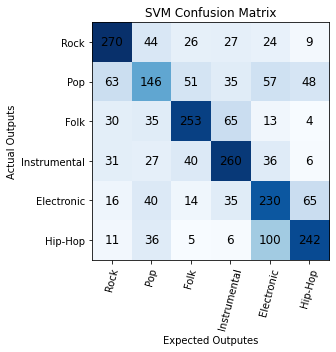

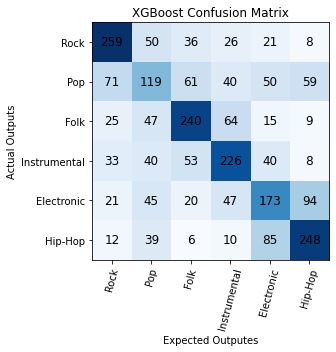

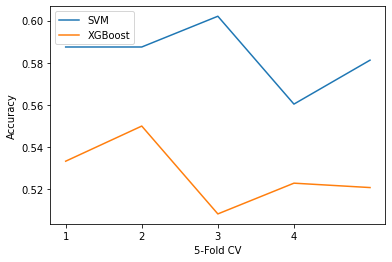

At 99% Confidence Interval :

 True Classification Accuracy of SVM is likely between 55.779000197118165 and 60.970999802881835

 True Classification Accuracy of XGBoost is likely between 50.0789976406353 and 55.337669026031364


In [26]:
# Extract PCA features.
X_train,X_test = get_pca_features(path_to_dataset,'train.csv','train_extracted','test_idx.csv','test_extracted',100)
Y_train = get_training_labels(path_to_dataset,'train.csv')

# Cross Validate PCA Features.
cross_validate(np.array(X_train),np.array(Y_train),"pca")

# Classify PCA Test Features using SVM and XGB Classifiers.
y_test_svm = classify_dataset_svm(X_train,Y_train,X_test)
y_test_xgb = classify_dataset_xgb(X_train,Y_train,X_test)
Y_test = pd.read_csv(os.path.join(path_to_dataset,'test_idx.csv'))
Y_test['genre'] = y_test_svm.tolist()
Y_test = Y_test.rename(columns={"new_id":"id"})
Y_test.to_csv(os.path.join(path_to_dataset,'test_svm_pca.csv'),index=False)
Y_test['genre'] = y_test_xgb.tolist()
Y_test = Y_test.rename(columns={"new_id":"id"})
Y_test.to_csv(os.path.join(path_to_dataset,'test_xgb_pca.csv'),index=False)

**Random Forest vs Logistic Regression on MFCC**

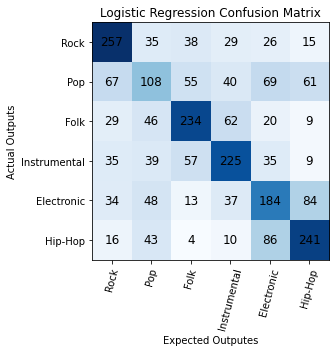

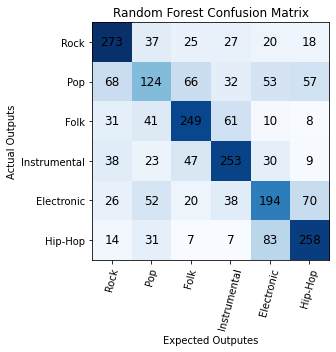

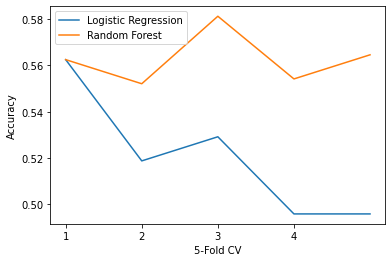

At 99% Confidence Interval :

 True Classification Accuracy of Logistic Regression is likely between 49.41066135787388 and 54.67267197545945

 True Classification Accuracy of Random Forest is likely between 53.67939546905034 and 58.90393786428299


In [27]:
# Extract MFCC features and standardizing them.
X_train = get_mfcc_features(path_to_dataset,'train.csv','train_extracted')
Y_train = get_training_labels(path_to_dataset,'train.csv')
X_test = get_mfcc_features(path_to_dataset,'test_idx.csv','test_extracted')
X_train,X_test = standardize_features(X_train,X_test)

# Cross Validate MFCC Features.
cross_validate(np.array(X_train),np.array(Y_train).flatten(),"mfcc")

# Classify MFCC Test Features using Logistic Regression and Random Forest Classifiers.
y_test_lr = classify_dataset_lr(X_train,Y_train,X_test)
y_test_rf = classify_dataset_rf(X_train,Y_train,X_test)
Y_test = pd.read_csv(os.path.join(path_to_dataset,'test_idx.csv'))
Y_test['genre'] = y_test_lr.tolist()
Y_test = Y_test.rename(columns={'new_id':'id'})
Y_test.to_csv(os.path.join(path_to_dataset,'test_lr_mfcc.csv'),index=False)
Y_test['genre'] = y_test_rf.tolist()
Y_test = Y_test.rename(columns={"new_id":"id"})
Y_test.to_csv(os.path.join(path_to_dataset,'test_rf_mfcc.csv'),index=False)

**Random Forest vs Logistic Regression on STFT**

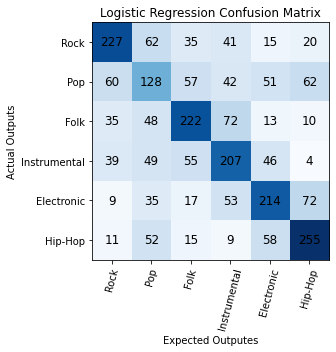

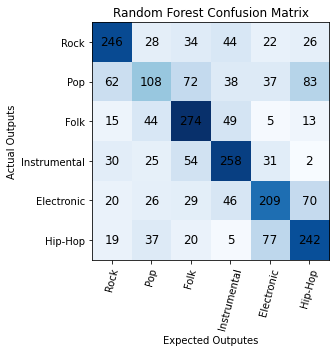

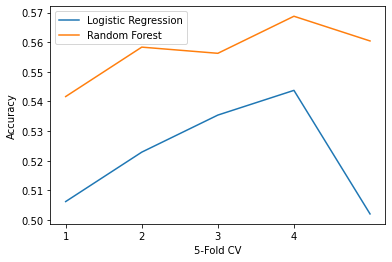

At 99% Confidence Interval :

 True Classification Accuracy of Logistic Regression is likely between 49.57770139929242 and 54.83896526737425

 True Classification Accuracy of Random Forest is likely between 53.09234875579932 and 58.32431791086735


In [28]:
# Extract STFT features and standardize them.
X_train = get_stft_features(path_to_dataset,'train.csv','train_extracted')
Y_train = get_training_labels(path_to_dataset,'train.csv')
X_test = get_stft_features(path_to_dataset,'test_idx.csv','test_extracted')
X_train,X_test = standardize_features(X_train,X_test)

# Cross Validate STFT Features.
cross_validate(np.array(X_train),np.array(Y_train).flatten(),"stft")

# Classify STFT Test Features using Logistic Regression and Random Forest Classifiers.
y_test_lr = classify_dataset_lr(X_train,Y_train,X_test)
y_test_rf = classify_dataset_rf(X_train,Y_train,X_test)
Y_test = pd.read_csv(os.path.join(path_to_dataset,'test_idx.csv'))
Y_test['genre'] = y_test_lr.tolist()
Y_test = Y_test.rename(columns={'new_id':'id'})
Y_test.to_csv(os.path.join(path_to_dataset,'test_lr_stft.csv'),index=False)
Y_test['genre'] = y_test_rf.tolist()
Y_test = Y_test.rename(columns={"new_id":"id"})
Y_test.to_csv(os.path.join(path_to_dataset,'test_rf_stft.csv'),index=False)


**2-D CNN vs 1-D CNN on Spectrograms**

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 125, 315, 32)      544       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 78, 32)        0         
_________________________________________________________________
activation_41 (Activation)   (None, 31, 78, 32)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 31, 78, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 31, 78, 64)        32832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 19, 64)         0         
_________________________________________________________________
activation_42 (Activation)   (None, 7, 19, 64)       

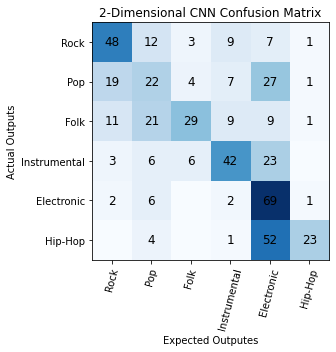



 Accuracy of 2-D CNN on Validation Dataset is 48.541666666666664


 At 99% Confidence Interval :

 True Classification Accuracy of 2-D CNN is likely between 42.65615415822875 and 54.42717917510458


In [54]:
# Get the spectrograms
X_train,Y_train,X_val,Y_val, X_test = get_spectrograms(path_to_dataset,'train.csv','train_extracted', 'test_idx.csv','test_extracted')
label_names=["Rock","Pop","Folk","Instrumental","Electronic","Hip-Hop"]

# Applying 2-D Convolution Neural Network on the spectrograms.
model = get_2d_cnn_model(X_train[0].shape)
model.fit(np.array(X_train), Y_train, epochs=20, batch_size=32, validation_data= (np.array(X_val), Y_val))

# Predict the Test dataset using the model and save results to a CSV file.
Y_test_nn = np.argmax(model.predict(np.array(X_test)),axis=1)
Y_test = pd.read_csv(os.path.join(path_to_dataset,'test_idx.csv'))
Y_test['genre'] = Y_test_nn.tolist()
Y_test = Y_test.rename(columns={'new_id':'id'})
Y_test.to_csv(os.path.join(path_to_dataset,'test_2d_cnn.csv'),index=False)

# Plot Confusion matrix using validation predictions.
Y_val_pred = np.argmax(model.predict(np.array(X_val)), axis=1)
Y_val_true = np.argmax(Y_val, axis=1)
Y_val_pred= [label_names[Y_val_pred[i]] for i in range(len(Y_val_pred))]
Y_val_true= [label_names[Y_val_true[i]] for i in range(len(Y_val_true))]
plot_confusion_matrix(Y_val_true,Y_val_pred,label_names,"2-Dimensional CNN")

accuracy= accuracy_score(Y_val_pred,Y_val_true)
radius = 2.58 * np.sqrt(accuracy*(1-accuracy)/len(Y_val_true))
accuracy_min =  (accuracy - radius)*100
accuracy_max =  (accuracy + radius)*100

print('\n\n Accuracy of 2-D CNN on Validation Dataset is ' + str(accuracy*100))
print('\n\n At 99% Confidence Interval :')
print('\n True Classification Accuracy of 2-D CNN is likely between ' + str(accuracy_min) + ' and ' + str(accuracy_max)) 




Train on 1920 samples, validate on 480 samples
Epoch 1/15
1920/1920 [==============================] - 68s 35ms/step - loss: 2.0557 - accuracy: 0.3458 - val_loss: 7.8646 - val_accuracy: 0.1729
Epoch 2/15
1920/1920 [==============================] - 67s 35ms/step - loss: 1.6759 - accuracy: 0.3370 - val_loss: 1.7659 - val_accuracy: 0.2708
Epoch 3/15
1920/1920 [==============================] - 67s 35ms/step - loss: 1.5864 - accuracy: 0.3536 - val_loss: 1.6494 - val_accuracy: 0.3187
Epoch 4/15
1920/1920 [==============================] - 66s 35ms/step - loss: 1.5177 - accuracy: 0.3807 - val_loss: 1.4827 - val_accuracy: 0.4104
Epoch 5/15
1920/1920 [==============================] - 67s 35ms/step - loss: 1.4566 - accuracy: 0.4172 - val_loss: 1.7152 - val_accuracy: 0.3500
Epoch 6/15
1920/1920 [==============================] - 66s 35ms/step - loss: 1.4530 - accuracy: 0.4078 - val_loss: 1.4238 - val_accuracy: 0.4229
Epoch 7/15
1920/1920 [==============================] - 69s 36ms/step - loss:

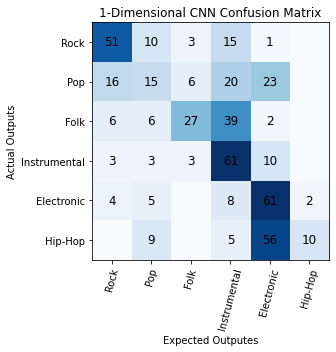



 Accuracy of 1-D CNN on Validation Dataset is 46.875


 At 99% Confidence Interval :

 True Classification Accuracy of 1-D CNN is likely between 40.99849379347622 and 52.75150620652378


In [53]:
# Applying 2-D Convolution Neural Network on the spectrograms.
model = get_1d_cnn_model(X_train[0].shape)
model.fit(np.array(X_train), Y_train, epochs=15, batch_size=32, validation_data= (np.array(X_val), Y_val))
print(model.summary())
# Predict the Test dataset using the model and save results to a CSV file.
Y_test_nn = np.argmax(model.predict(np.array(X_test)),axis=1)
Y_test = pd.read_csv(os.path.join(path_to_dataset,'test_idx.csv'))
Y_test['genre'] = Y_test_nn.tolist()
Y_test = Y_test.rename(columns={'new_id':'id'})
Y_test.to_csv(os.path.join(path_to_dataset,'test_1d_cnn.csv'),index=False)

# Plot Confusion matrix using validation predictions.
Y_val_pred = np.argmax(model.predict(np.array(X_val)), axis=1)
Y_val_true = np.argmax(Y_val, axis=1)
Y_val_pred= [label_names[Y_val_pred[i]] for i in range(len(Y_val_pred))]
Y_val_true= [label_names[Y_val_true[i]] for i in range(len(Y_val_true))]
plot_confusion_matrix(Y_val_true,Y_val_pred,label_names,"1-Dimensional CNN")

accuracy= accuracy_score(Y_val_pred,Y_val_true)
radius = 2.58 * np.sqrt(accuracy*(1-accuracy)/len(Y_val_pred))
accuracy_min =  (accuracy - radius)*100
accuracy_max =  (accuracy + radius)*100

print('\n\n Accuracy of 1-D CNN on Validation Dataset is ' + str(accuracy*100))
print('\n\n At 99% Confidence Interval :')
print('\n True Classification Accuracy of 1-D CNN is likely between ' + str(accuracy_min) + ' and ' + str(accuracy_max)) 